## Cellpose Segmentation Overview

This notebook demonstrates running Cellpose on a sample image and comparing results across diameter settings.

- Checks environment (Torch/CUDA) and imports the correct Cellpose model (v3/v4).
- Loads a test image from the repo data.
- Runs segmentation: baseline (no diameter), `diameter=None`, and explicit diameters.
- Visualizes overlays in a tidy grid and saves the figure to `figures/`.
- Performs a simple instance analysis (size + saturation) with scatter plots and colored overlays.

Tip: Use the Pixi kernel for GPU-enabled runs (see README).

### Check environment

In this cell we make sure we have torch, a working GPU and cudnn

In [4]:
# First, test if environment is working correctly by checking versions
import torch
import numpy as np

print("Torch version:", torch.__version__)
print("NumPy version:", np.__version__)

print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))

print("cuDNN available:", torch.backends.cudnn.is_available())
print("cuDNN version:", torch.backends.cudnn.version())

Torch version: 2.6.0
NumPy version: 1.26.4
CUDA available: True
GPU name: NVIDIA GeForce RTX 3090
cuDNN available: True
cuDNN version: 91002


### Import cellpose

... and check major version.  Version 4 is the sam version.  Earlier versions are built on unets. 

In [5]:
import cellpose
import os
import matplotlib.pyplot as plt
from cellpose import models
from skimage.io import imread
from tnia.plotting.plt_helper import mask_overlay

major_number = cellpose.version.split('.')[0]
print(f"Cellpose version: {cellpose.version} (major number: {major_number})")

if major_number == '3':
    model = models.Cellpose(gpu=True, model_type='cyto2')
elif major_number == '4':
    model = models.CellposeModel(gpu=True)


Cellpose version: 4.0.8 (major number: 4)


### Load and display example image

Available images:
[0] Snap_060 (2).jpg
[1] Snap_055.jpg
[2] TestHidden_005.bmp
[3] Snap_061 (2).jpg
[4] BloodImage_00134_jpg.rf.0d9da503b62e0034a2819a39cce7e7d9.jpg
[5] BloodImage_00154_jpg.rf.e5b45569e9cbede1ed36f82f14566c29.jpg
Selected index: 0
Using image: ..\..\..\reproducible-dl-seg-article\data\Blood cell Cancer [ALL]\benign\Snap_060 (2).jpg
Image tag: Snap_060 (2)
Loaded image shape: (768, 1024, 3), dtype: uint8


(-0.5, 1023.5, 767.5, -0.5)

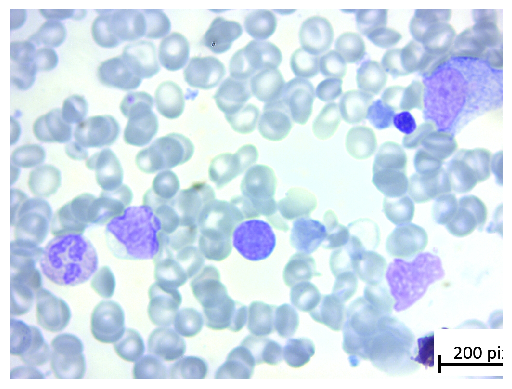

In [6]:
# Choose sample image by number (simple like 10_batch_process)
import os
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt

# Available image options (indexed)
image_options = [
    r"..\..\..\reproducible-dl-seg-article\data\Blood cell Cancer [ALL]\benign\Snap_060 (2).jpg",
    r"..\..\..\reproducible-dl-seg-article\data\Blood cell Cancer [ALL]\benign\Snap_055.jpg",
    r"..\..\..\reproducible-dl-seg-article\data\SOTA\TestHidden_005.bmp",
    r"..\..\..\reproducible-dl-seg-article\data\Blood cell Cancer [ALL]\benign\Snap_061 (2).jpg",
    r"..\..\..\reproducible-dl-seg-article\data\addhopin blood cells\test\images\BloodImage_00134_jpg.rf.0d9da503b62e0034a2819a39cce7e7d9.jpg",
    r"..\..\..\reproducible-dl-seg-article\data\addhopin blood cells\test\images\BloodImage_00154_jpg.rf.e5b45569e9cbede1ed36f82f14566c29.jpg",
]

# Index guide (set selection_index below):
# [0] Snap_060 (2).jpg
# [1] Snap_055.jpg
# [2] TestHidden_005.bmp
# [3] Snap_061 (2).jpg
# [4] BloodImage_00134_....jpg
# [5] BloodImage_00154_....jpg

# Choose by number: change this to desired index
selection_index = 0 

print("Available images:")
for i, p in enumerate(image_options):
    print(f"[{i}] {os.path.basename(p)}")
print(f"Selected index: {selection_index}")

image_path = image_options[selection_index]
image_name = os.path.splitext(os.path.basename(image_path))[0]
print("Using image:", image_path)
print("Image tag:", image_name)

img = imread(image_path)

if len(img.shape) == 2:
    img = np.expand_dims(img, axis=2)
    img = np.repeat(img, 3, axis=2)

print(f"Loaded image shape: {img.shape}, dtype: {img.dtype}")
plt.imshow(img)
plt.axis("off")

### Run cellpose

Use several diffferent diameters and save results in a dictionary

In [7]:
# Evaluate model with various diameter settings
# - No diameter passed (uses model default)
# - diameter=None (let model estimate)
# - Explicit diameters: 30, 60, 90, 120

# Baselines
result_no_diameter = model.eval(img)  # no diameter passed
result_diameter_none = model.eval(img, diameter=None)  # let model estimate diameter

# Explicit diameters
diameters = [30, 60, 90, 120]
results_by_diameter = {}
for d in diameters:
    results_by_diameter[d] = model.eval(img, diameter=d)


## Plot ground truth and cellpose results overlays. 

Saved overlays figure to: figures\cellpose_overlays_Snap_060_(2)_v4.0.8.png


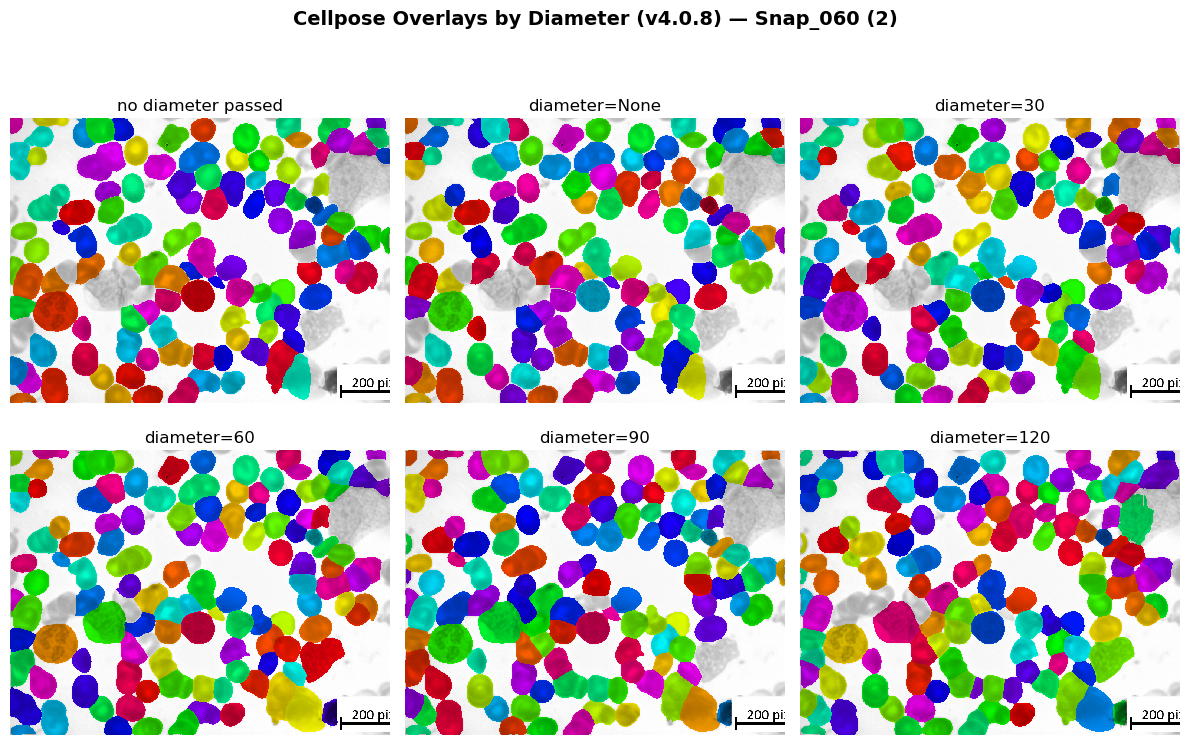

In [8]:
from tnia.plotting.plt_helper import mask_overlay
import matplotlib.pyplot as plt
import os

# Build overlays for each result
overlays = []
labels = []

# No diameter passed
overlays.append(mask_overlay(img, result_no_diameter[0]))
labels.append("no diameter passed")

# diameter=None
overlays.append(mask_overlay(img, result_diameter_none[0]))
labels.append("diameter=None")

# Explicit diameters
for d in diameters:
    res = results_by_diameter[d]
    overlays.append(mask_overlay(img, res[0]))
    labels.append(f"diameter={d}")

# Plot all overlays in a grid
n = len(overlays)
cols = 3
rows = (n + cols - 1) // cols
fig = plt.figure(figsize=(4 * cols, 4 * rows))
for i, (ov, lbl) in enumerate(zip(overlays, labels), start=1):
    ax = plt.subplot(rows, cols, i)
    ax.imshow(ov)
    ax.set_title(lbl)
    ax.axis("off")

# Nice figure title with Cellpose version and image name
fig.suptitle(f"Cellpose Overlays by Diameter (v{cellpose.version}) — {image_name}", fontsize=14, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save figure to figures/ under this notebook folder
figures_dir = "figures"
os.makedirs(figures_dir, exist_ok=True)
version_tag = cellpose.version.replace(" ", "_")
image_tag = image_name.replace(" ", "_")
outfile = os.path.join(figures_dir, f"cellpose_overlays_{image_tag}_v{version_tag}.png")
fig.savefig(outfile, dpi=200, bbox_inches="tight")
print(f"Saved overlays figure to: {outfile}")

plt.show()
